In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

plt.rcParams.update({"figure.figsize": (6, 6),
                      "axes.facecolor": "white",
                      "axes.edgecolor": "black"})

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sb.color_palette('colorblind'))
font = {'family': 'sans-serif',
         'weight': 'normal',
         'size': 14}
plt.rc('font', **font)

file_path = 'Synthetic_ICU_Dataset_CGPT.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['Patient_ID'])
df.head()

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10423 entries, 0 to 10422
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Admission Hospital         10423 non-null  object
 1   Admission Unit             10423 non-null  object
 2   Admission Date             10423 non-null  object
 3   Admission Decision Time    10423 non-null  object
 4   Admission Time             10423 non-null  object
 5   Discharge Date             10423 non-null  object
 6   Survived                   10423 non-null  int64 
 7   Diagnosis                  10423 non-null  object
 8   Length of Stay             10423 non-null  int64 
 9   Cardiovascular Support     10423 non-null  int64 
 10  Dialysis Support           10423 non-null  int64 
 11  Invasive Ventilation       10423 non-null  int64 
 12  Nutrition                  10423 non-null  int64 
 13  Age                        10423 non-null  int64 
 14  Gender

In [3]:
categorical_columns = ['Admission Hospital', 'Admission Unit', 'Diagnosis', 'Gender']
for column in categorical_columns:
    df[column] = df[column].astype('category')

category_names = {col: df[col].cat.categories for col in categorical_columns}

df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
# df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print(df.head())

  Admission Date Admission Decision Time Admission Time Discharge Date  \
0     2022-07-19                   10:11          12:11     02/08/2022   
1     2022-08-22                   07:48          09:48     24/08/2022   
2     2022-01-26                   16:50          17:50     05/02/2022   
3     2022-02-11                   19:09          22:09     15/02/2022   
4     2022-03-02                   00:23          02:23     06/03/2022   

   Survived  Length of Stay  Cardiovascular Support  Dialysis Support  \
0         0              14                       1                 0   
1         1               2                       0                 0   
2         0              10                       1                 0   
3         1               4                       0                 0   
4         1               4                       0                 0   

   Invasive Ventilation  Nutrition  ...  Diagnosis_Sepsis  \
0                     0          1  ...             Fal

In [4]:
from datetime import datetime, timedelta

df['Admission Date'] = pd.to_datetime(df['Admission Date'], format='%Y-%m-%d')
df['Admission Decision Time'] = pd.to_datetime(df['Admission Decision Time'], format='%H:%M').dt.time
df['Admission Time'] = pd.to_datetime(df['Admission Time'], format='%H:%M').dt.time
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], format='%d/%m/%Y')

def calculate_wait_time(row):
    decision_datetime = datetime.combine(row['Admission Date'], row['Admission Decision Time'])
    admission_datetime = datetime.combine(row['Admission Date'], row['Admission Time'])

    if admission_datetime < decision_datetime:
        admission_datetime += timedelta(days=1)

    return (admission_datetime - decision_datetime).total_seconds() / 3600

df['Wait Time (hrs)'] = df.apply(calculate_wait_time, axis=1)

df['Month'] = df['Admission Date'].dt.month
season_mapping = {
    11: 'Winter', 12: 'Winter', 1: 'Winter',
    2: 'Spring', 3: 'Spring', 4: 'Spring',
    5: 'Summer', 6: 'Summer', 7: 'Summer',
    8: 'Autumn', 9: 'Autumn', 10: 'Autumn'
}

df['Season'] = df['Month'].map(season_mapping)

df.to_csv('Synthetic_ICU_Dataset_CGPT2.csv', index=False)

print(df[['Admission Date', 'Month', 'Season', 'Wait Time (hrs)']].head())

  Admission Date  Month  Season  Wait Time (hrs)
0     2022-07-19      7  Summer              2.0
1     2022-08-22      8  Autumn              2.0
2     2022-01-26      1  Winter              1.0
3     2022-02-11      2  Spring              3.0
4     2022-03-02      3  Spring              2.0


In [5]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df['Season'] = pd.Categorical(df['Season'], categories=season_order, ordered=True)
season_tally = df['Season'].value_counts().reindex(season_order)

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['Month Name'] = df['Month'].map(month_mapping)  
df['Month Name'] = pd.Categorical(df['Month Name'], categories=month_order, ordered=True)
month_tally = df['Month Name'].value_counts().reindex(month_order)

In [6]:
from pycaret.time_series import *

df = df.sort_values(by='Admission Date')

df.set_index('Admission Date', inplace=True)

df_daily = df.resample('D').size() 


df_daily = df_daily.to_frame(name='ICU_Admissions')
print(df_daily.head()) 
print(df_daily.tail()) 
print(df_daily.columns) 


ts_setup = setup(
    data=df_daily,
    target='ICU_Admissions', 
    fold_strategy='expanding',
    session_id=123,
    # seasonal_period=365, 
    transform_target=None
)

print(ts_setup)

best_model = compare_models()
print(f"Best model: {best_model}")

future_predictions = predict_model(best_model, fh=100)
print(future_predictions)

                ICU_Admissions
Admission Date                
2022-01-01                  27
2022-01-02                  22
2022-01-03                  28
2022-01-04                  26
2022-01-05                  28
                ICU_Admissions
Admission Date                
2022-12-27                  26
2022-12-28                  30
2022-12-29                  27
2022-12-30                  29
2022-12-31                  36
Index(['ICU_Admissions'], dtype='object')


,Description,Value
0,session_id,123
1,Target,ICU_Admissions
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(365, 1)"
5,Transformed data shape,"(365, 1)"
6,Transformed train set shape,"(364, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
auto_arima,Auto ARIMA,0.1441,0.1156,0.8396,0.8396,0.0296,0.0295,0.7200
arima,ARIMA,0.1774,0.1424,1.0339,1.0339,0.0364,0.0363,0.0800
exp_smooth,Exponential Smoothing,0.1804,0.1448,1.0510,1.0510,0.0377,0.0369,0.0300
theta,Theta Forecaster,0.1961,0.1574,1.1425,1.1425,0.0403,0.0401,0.0300
grand_means,Grand Means Forecaster,0.1985,0.1593,1.1565,1.1565,0.0406,0.0406,1.7167
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.2080,0.1669,1.2119,1.2119,0.0415,0.0424,0.0500
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.2092,0.1679,1.2190,1.2190,0.0421,0.0427,0.0600
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.2092,0.1679,1.2190,1.2190,0.0421,0.0427,0.2400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.2092,0.1679,1.2190,1.2190,0.0421,0.0427,0.1667
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2113,0.1695,1.2309,1.2309,0.0423,0.0431,0.0433


Best model: AutoARIMA(random_state=123, suppress_warnings=True)
             y_pred
2022-12-31  28.3596
2023-01-01  28.5896
2023-01-02  28.5144
2023-01-03  28.5410
2023-01-04  28.5322
...             ...
2023-04-05  28.5345
2023-04-06  28.5345
2023-04-07  28.5345
2023-04-08  28.5345
2023-04-09  28.5345

[100 rows x 1 columns]


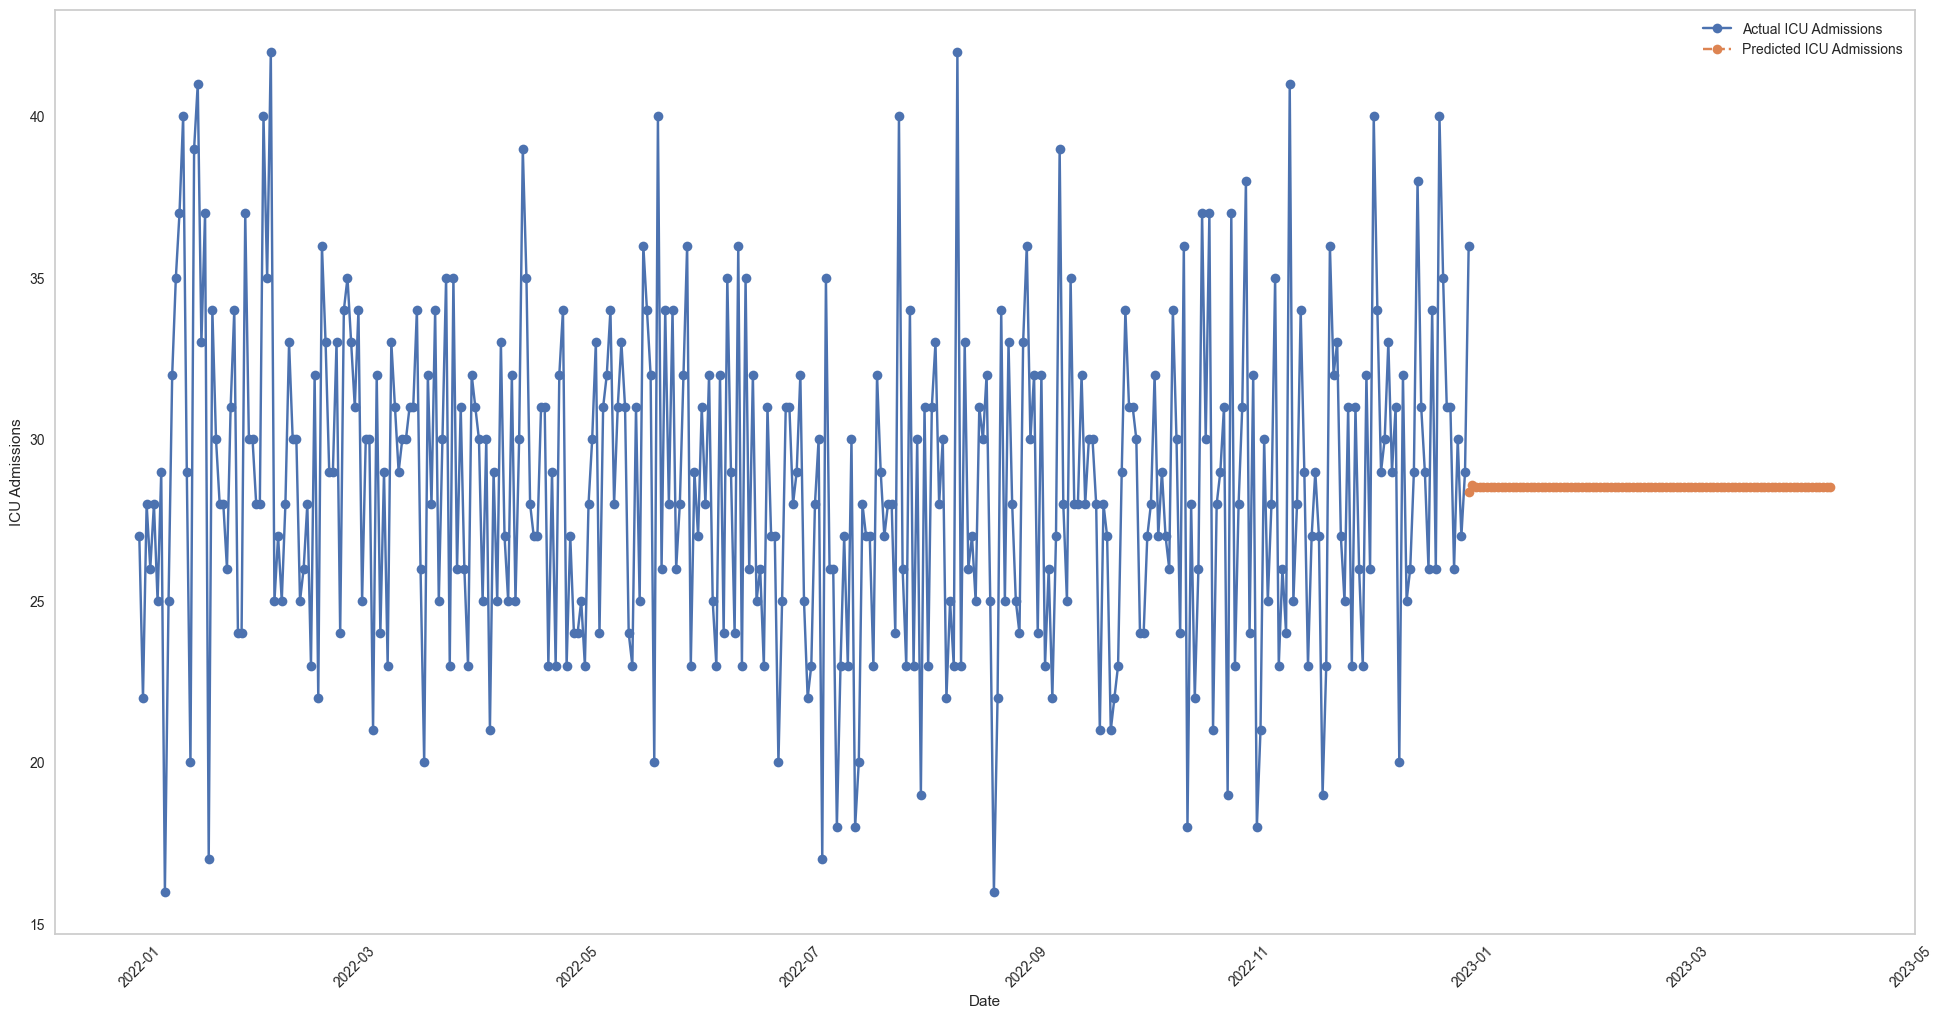

In [7]:
plt.figure(figsize=(24, 12))
plt.plot(df_daily.index, df_daily['ICU_Admissions'], label='Actual ICU Admissions', color='#4C72B0', marker='o')

plt.plot(future_predictions.index, future_predictions['y_pred'], label='Predicted ICU Admissions', color='#DD8452', linestyle='dashed', marker='o')

# plt.fill_between(
#     future_predictions.index,
#     future_predictions['lower'],
#     future_predictions['upper'],
#     color='blue',
#     alpha=0.2,
#     label='Confidence Interval'
# )
plt.xlabel('Date')
plt.ylabel('ICU Admissions')
# plt.title
plt.legend()
plt.xticks(rotation=45)
plt.grid()

plt.show()

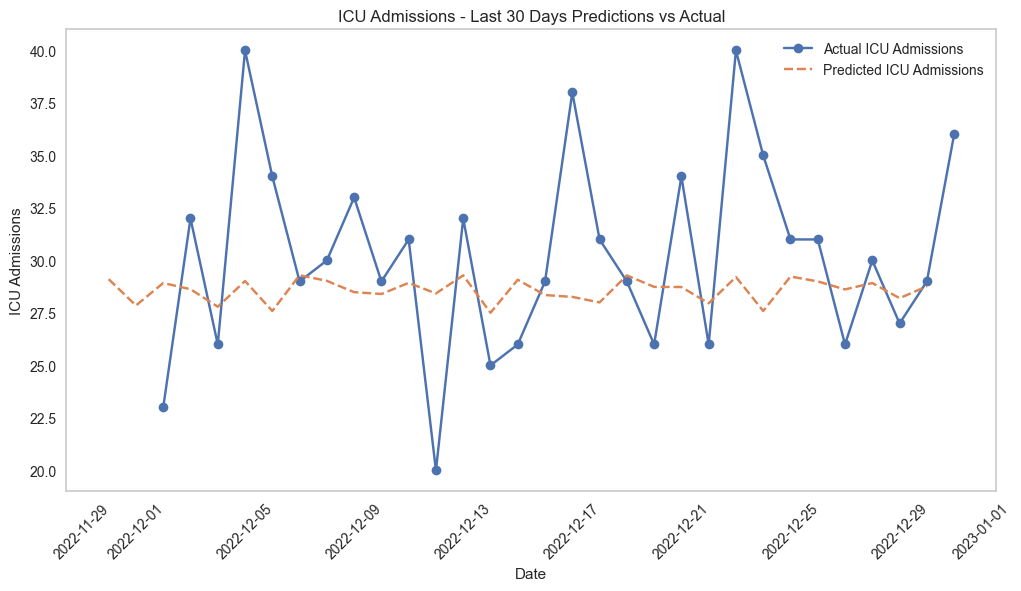

In [8]:
fh = list(range(-30, 1)) 
past_predictions = predict_model(best_model, fh=fh)


actual_last_30 = df_daily.iloc[-30:]


plt.figure(figsize=(12, 6))
plt.plot(actual_last_30.index, actual_last_30['ICU_Admissions'], label='Actual ICU Admissions', color='#4C72B0', marker='o')
plt.plot(past_predictions.index, past_predictions['y_pred'], label='Predicted ICU Admissions', color='#DD8452', linestyle='dashed', marker='x')

plt.xlabel('Date')
plt.ylabel('ICU Admissions')
plt.title('ICU Admissions - Last 30 Days Predictions vs Actual')
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# Show plot
plt.show()